In [1]:
#r "nuget: BenchmarkDotNet, 0.13.9"
#r "nuget: Microsoft.Playwright, 1.39.0"
#r "nuget: NUlid, 1.7.1"
#r "bin/Release/net6.0/ConsoleBenchmark.dll"

using ConsoleBenchmark;
using NUlid;

Installed Packages BenchmarkDotNet, 0.13.9 Microsoft.Playwright, 1.39.0 NUlid, 1.7.1

In [2]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var jsonElement = await fixture.Expression1JsonElementEvaluateAsync();
    stopWatch.Stop();
}
Console.WriteLine($"{nameof(PlaywrightFixture.Expression1JsonElementEvaluateAsync)}: {stopWatch.ElapsedMilliseconds}ms");

Expression1JsonElementEvaluateAsync: 16ms


In [3]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var gameState = await fixture.Expression2StringDeserializeEvaluateAsync();
    stopWatch.Stop();
}
Console.WriteLine($"{nameof(PlaywrightFixture.Expression2StringDeserializeEvaluateAsync)}: {stopWatch.ElapsedMilliseconds}ms");

Expression2StringDeserializeEvaluateAsync: 10ms



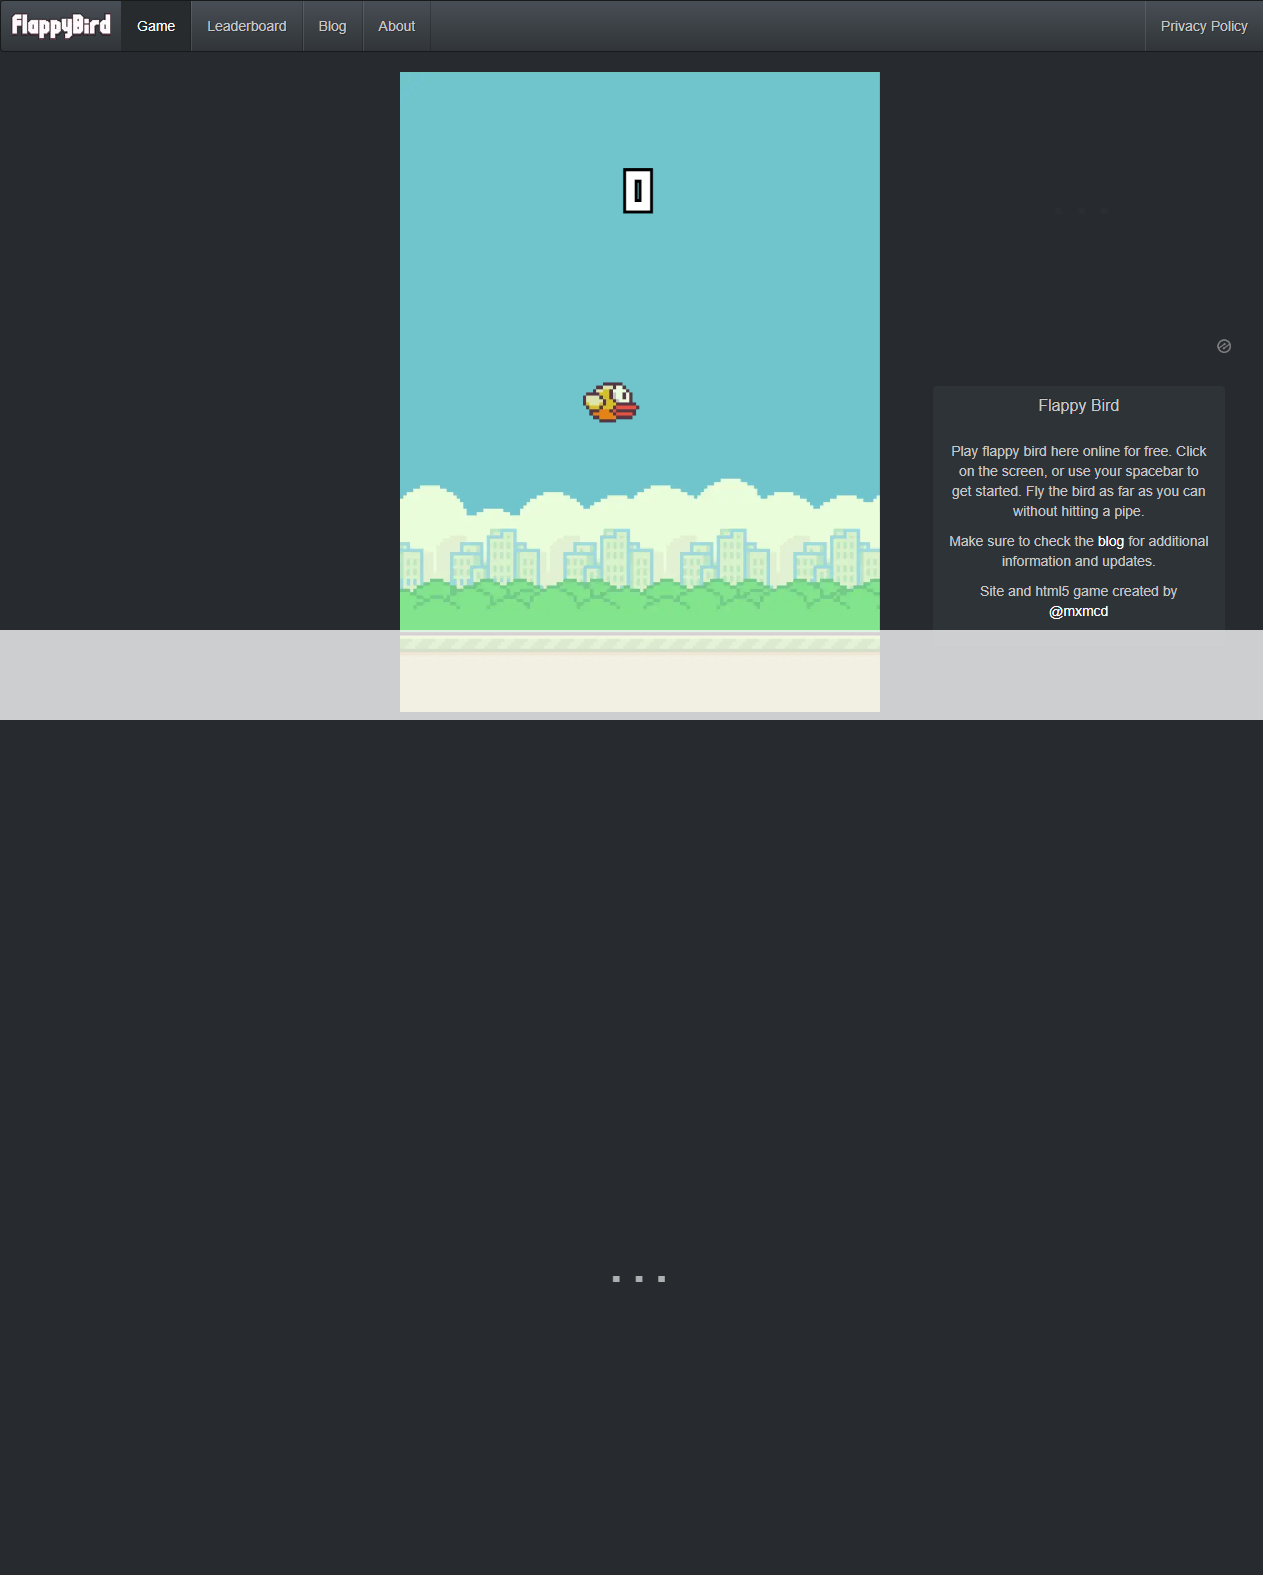

ScreenshotBytesAsync: 225ms


In [4]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var screenshotBytes = await fixture.ScreenshotBytesAsync();
    var base64str = Convert.ToBase64String(screenshotBytes);
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(PlaywrightFixture.ScreenshotBytesAsync)}: {stopWatch.ElapsedMilliseconds}ms");


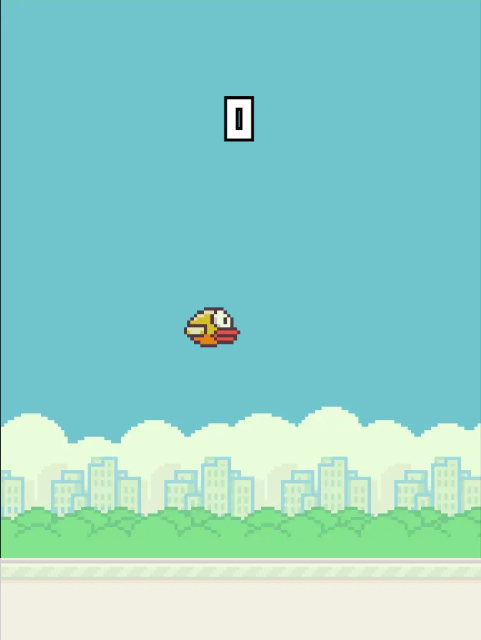

QuerySelectorAsyncScreenshotAsync: 269ms


In [5]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var screenshotBytes = await fixture.QuerySelectorAsyncScreenshotAsync();
    var base64str = Convert.ToBase64String(screenshotBytes);
    stopWatch.Stop();
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(PlaywrightFixture.QuerySelectorAsyncScreenshotAsync)}: {stopWatch.ElapsedMilliseconds}ms");

In [6]:
var stopWatch = new System.Diagnostics.Stopwatch();
await using (var fixture = await PlaywrightFixture.CreateAsync()){
    stopWatch.Start();
    var path = await fixture.ScreenshotSaveAsync();
    stopWatch.Stop();
    var screenshotBytes = System.IO.File.ReadAllBytes(path);
    var base64str = Convert.ToBase64String(screenshotBytes);
    display(path);
    display(Microsoft.DotNet.Interactive.Formatting.PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}
Console.WriteLine($"{nameof(PlaywrightFixture.ScreenshotSaveAsync)}: {stopWatch.ElapsedMilliseconds}ms");

Error: (6,27): error CS0103: The name 'File' does not exist in the current context

In [7]:
Ulid newUlid = Ulid.NewUlid();
Console.WriteLine(newUlid);

01HDAPJRHH1KPA0AZZKRB3SB3B



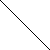


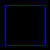

In [8]:
using System;
using System.IO;
using System.Drawing;
using System.Drawing.Imaging;
using Microsoft.DotNet.Interactive.Formatting;

MemoryStream memStream;
Bitmap b = new Bitmap(50, 50);
Graphics g = Graphics.FromImage(b);

void d()
{
memStream = new MemoryStream();
b.Save(memStream, ImageFormat.Png);
string base64str = Convert.ToBase64String(memStream.ToArray());
display(PocketViewTags.img[src: "data:image/png;base64," + base64str]);
}

g.Clear(Color.White);
g.DrawLine(Pens.Black, 0, 0, b.Width, b.Height);
d();

g.Clear(Color.Black);
g.DrawRectangle(Pens.Blue, 5, 5, b.Width-10, b.Height-10);
d();